<a href="https://colab.research.google.com/github/DerekHickey6/G-Colab-PyTorch/blob/main/PyTorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Workflow

In [4]:
what_were_covering = {1: "Data (prep and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making prediction and evaluating model (inference)",
                      5: "save and load a model",
                      6: "putting it all together"}


In [5]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

#check PyTorch version
torch.__version__

'2.8.0+cu126'

## 1. Data ( preparing and loading )

* get data into numberical representation
* build a model to learn patterns in the numberical representation

In [6]:
# create some *known* parameters with linear regression

weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # create a range and adds an extra dimension
y = weight * X + bias

X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [7]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

Three dataset -- School analogy
* Training set ( course material )
* validation set ( practice exam )
* test set ( final exam )

Generalization - the ability for a machine learning model to perform well on data it hasn't seen before

In [8]:
# Create a train/test split (80/20)
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split] ## makes training values for X and y to be 'up to {train_split}'
X_test, y_test = X[train_split:], y[train_split:] ## makes X and y test values 'from {train_split} and beyond'

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [9]:
# Build function to visualize our data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # Plot training dat in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

  # Are their predictions
  if predictions is not None:
    # Plot predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show legend
  plt.legend(prop={"size": 14});

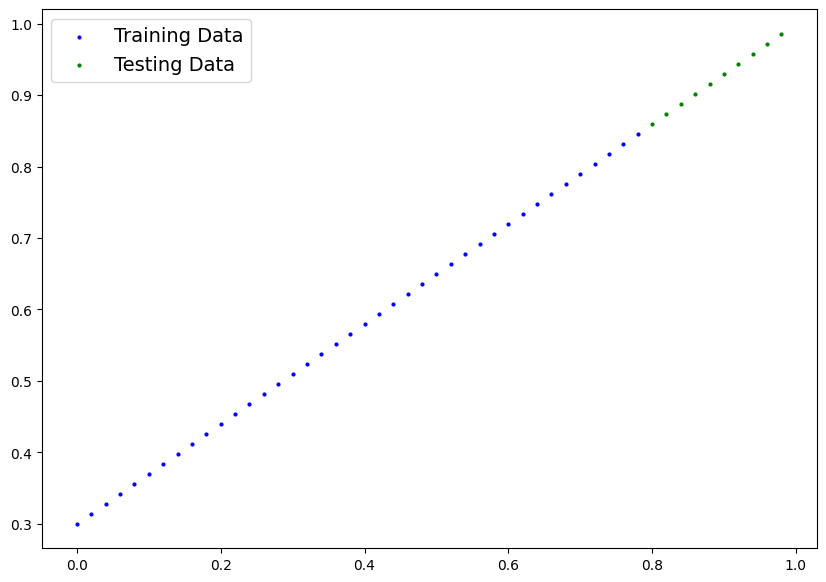

In [10]:
plot_predictions()

## 2. Building PyTorch model

* starts with random values (weight and bias)
* looks at training data
* adjusts the random values to better represent the ideal values ( values used to create data )

HOW!?
1. Gradient descent  - torch.autograd
2. Back Propagation

In [11]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):     # <- almost everything in pytorch inherits from nn.Module
  def __init__(self):
    super().__init__()

    self.weight = nn.Parameter(torch.randn(1, # <- starts with a random weight and try to adjust it to the ideal values
                                           requires_grad=True,   # tells model if this parameter be updated via gradient descent
                                           dtype=torch.float))   # PyTorch likes float32

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation performed at every call
  def forward(self, x: torch.Tensor) -> torch.Tensor:  # <- "x" is the input data
    return self.weight * x + self.bias  # linear regression formula

## PyTorch model Building essentials

* torch.nn - contains all of the building blocks for computational graphs ( a neural network can be considered a computationl graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch latyer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers live that help with gradient descent
* def forward() - all nn.Module subclasses require forward to be overwritten
  - this method defines what happens in the forward computation

* torch.utils.data.Dataset - represents a map between key (label) anmd sample ( feature) pairs of your data.
  - such as images and their associated labels

* torch.utils.data.Dataloader - Creates a python iterable over a torch dataset ( allowing you to iterate over your data)

### Checking the contents of our PyTorch model

`.parameters()`

In [12]:
# Create a random seed
torch.manual_seed(42)

# Create and instance of the model ( subclass of nn.Module )
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

to check our model's predictive powers, lets see how well it predicts y_test based on X_test

when we pass data through our model, its going to run it throug the forward() method


In [14]:
# Make predictions with model -- ideal model will take X_test and output y_test
with torch.inference_mode():  # context manager -- turns OFF gradient tracking, don't need to track if we are not training ( PyTorch keeps track of less data )
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [15]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

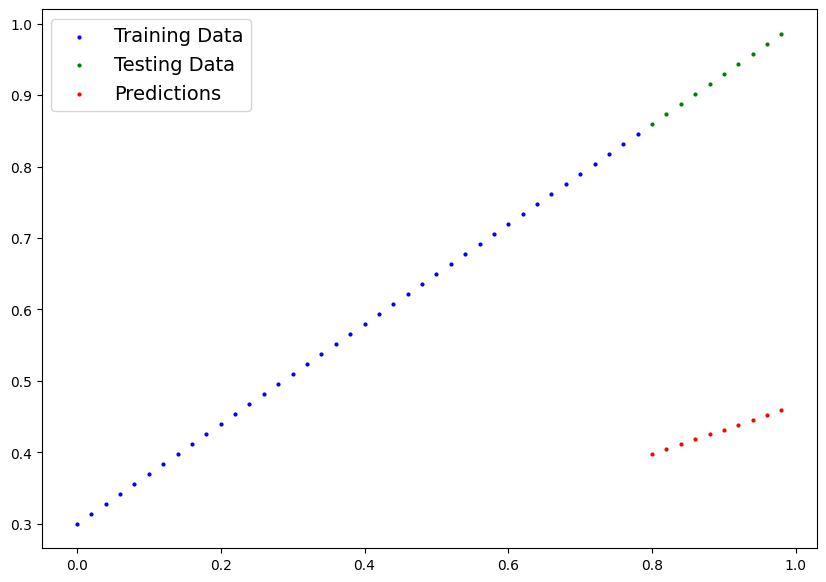

In [16]:
plot_predictions(predictions=y_preds)

## 3. Train model

the whole idea of training is for a model to move from *unknown* parameters to some *known* Parameter
AKA. from a poor representation of data to a better representation

One way to measure how poor or how wrong your models predictions are, is to use a *loss function*

* Note: Loss function may also be called criterion or cost function

things we need to train:

**Loss function:** A function to measure how wrong your models predictions are to the ideal outputs, so lower is better!!

**optimizer** Takes into account the loss of a model and adjust the model's parameters ( weight and bias ) to imporve the loss function

 - a training loop
 - a testing loop

In [17]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [18]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Setting up an optimizer and loss function

In [19]:
# Check out our models parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [20]:
# Setup a loss function -- measures how wrong out model is
loss_fn = nn.L1Loss()

# Setup an optimizer (Stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)   ## lr = Learning rate = possibly the most important hyperparameter (you can set) - defines the amount of change is made to params

## Building a train loop in PyTorch ( and testing loop )

Things we need in a training loop:

0. loop though the data
1. forward pass (this involves data moving through the model's `forward()` functions) to make predictions on data - also called forward propagations
2. calculate the loss (compare forward pass predictions to ground truth labels)
3. optimize zero grad
4. loss backward - move backwards through the network to calcuilate that gradient of each of the parameters of our model with respect to the loss (**back propagation**)
5. Optimizer step - use the optimizer to adjust our models parameters to try and improve the loss ( **Gradient descent** )

In [21]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we have set it outselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training Starts ###

# 0. loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)   # (input, target)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform back propagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer ( perform gradient descent )
  optimizer.step() # by default how the optimizer changes will accumulate through the loop... so we have to sero them above in step 3 for the next iterationm through the loop


  ### Testing Starts ###

  model_0.eval() # turns off different settings in the model that are not needed for evaluation/testing (droppout, batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking ( and other things not needed for testing)
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out whats happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    # print out model.state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict({'weight': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict({'weight': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict({'weight': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict({'weight': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict({'weight': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict({'weight': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict({'weight': tensor([0.5116]), 'bias': tensor([0.3788])})
Epoch: 70 | Loss: 0.034760899

In [22]:
import numpy as np
np.array(torch.tensor(loss_values).cpu().numpy())

/tmp/ipython-input-3856275706.py:2: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  np.array(torch.tensor(loss_values).cpu().numpy())


array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
       0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
       0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
       0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

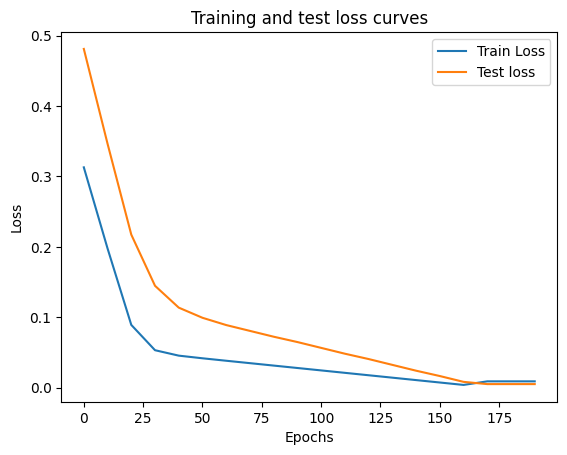

In [23]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [24]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

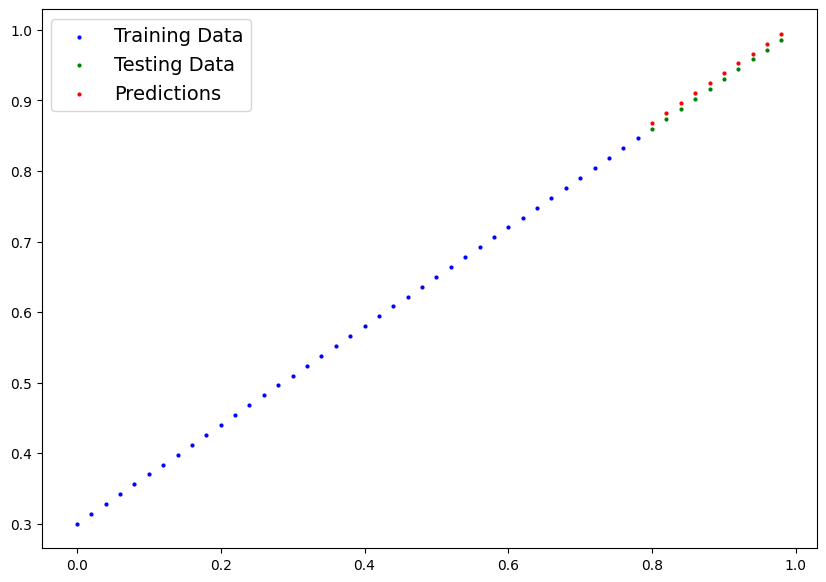

In [25]:
plot_predictions(predictions=y_preds_new)

## Saving (and loading) a model in PyTorch
to be able to use elsewhere

3 Mains methods:
* `torch.save` - allows you to save a pytorch object in Python pickle format
* `torch.load` - loads a save python object
* `torch.nn.Module.load_state_dict() - load a models saved state dictionary

In [26]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [27]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_first_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict()
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_first_model.pth


In [28]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1949 Oct 12 17:11 01_first_model.pth


## Loading a PyTorch model

In [29]:
# To load in a saved state_dict, we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [30]:
# Loaded with updated parameters
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [31]:
# Make some predicitons with out loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [32]:
# Make some model preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [33]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check pytorch version
torch.__version__

'2.8.0+cu126'

In [34]:
# Create device agnostic-code
# if we have access to a GPU, our code will use it
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [35]:
# Create some data using the linear regression formula y = weight * X + bias
weight = 0.7
bias = 0.3

# Create rnage values
start = 0
end = 1
step = 0.02

# Create X and Y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [36]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

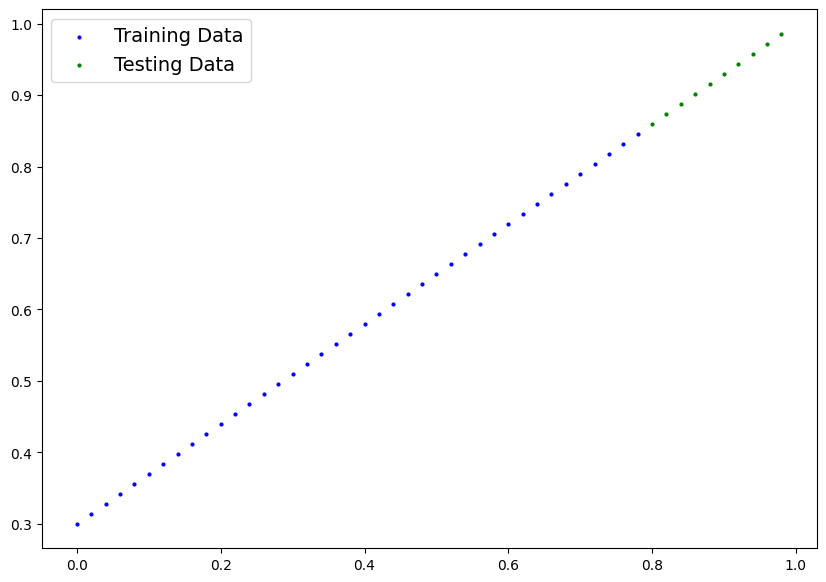

In [37]:
# Plot the data
# NOte: if you d(Xont have the plot predictions loaded --> error
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model
* Hello

In [38]:
# Create a linear model by subclassing nn.Module
from torch import nn
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters /also called: linear transform, probing layer, fulling connected layer, etc.
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [39]:
#Set the manual seed
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [40]:
# Check the model current device
next(model_1.parameters()).device


device(type='cpu')

In [41]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Train the model

* loss function
* optimizer
* training loop
* testing loop

In [42]:
# Setup the loss function
loss_fn  = nn.L1Loss() # Same as MAE

# Setup the optimizer with Stochastic Gradient Descent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01,)

In [43]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Loop through epochs
for epoch in range(epochs):
  # set model in train mode
  model_1.train()

  # 1. do the forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero the optimizier gradients (the accumulate by default)
  optimizer.zero_grad()

  # 4. perform backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing ###
  model_1.eval()

  with torch.inference_mode():
    # 1. do the forward pass
    test_pred = model_1(X_test)

    # 2. calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out whats happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0, Train loss: 0.55518, Test loss: 0.57398
Epoch: 10, Train loss: 0.43997, Test loss: 0.43927
Epoch: 20, Train loss: 0.32476, Test loss: 0.30456
Epoch: 30, Train loss: 0.20955, Test loss: 0.16985
Epoch: 40, Train loss: 0.09434, Test loss: 0.03514
Epoch: 50, Train loss: 0.02389, Test loss: 0.04785
Epoch: 60, Train loss: 0.01996, Test loss: 0.04580
Epoch: 70, Train loss: 0.01652, Test loss: 0.03753
Epoch: 80, Train loss: 0.01309, Test loss: 0.02994
Epoch: 90, Train loss: 0.00965, Test loss: 0.02167
Epoch: 100, Train loss: 0.00622, Test loss: 0.01409
Epoch: 110, Train loss: 0.00279, Test loss: 0.00581
Epoch: 120, Train loss: 0.00126, Test loss: 0.01380
Epoch: 130, Train loss: 0.00126, Test loss: 0.01380
Epoch: 140, Train loss: 0.00126, Test loss: 0.01380
Epoch: 150, Train loss: 0.00126, Test loss: 0.01380
Epoch: 160, Train loss: 0.00126, Test loss: 0.01380
Epoch: 170, Train loss: 0.00126, Test loss: 0.01380
Epoch: 180, Train loss: 0.00126, Test loss: 0.01380
Epoch: 190, Train loss:

In [44]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evauluating predictions

In [45]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

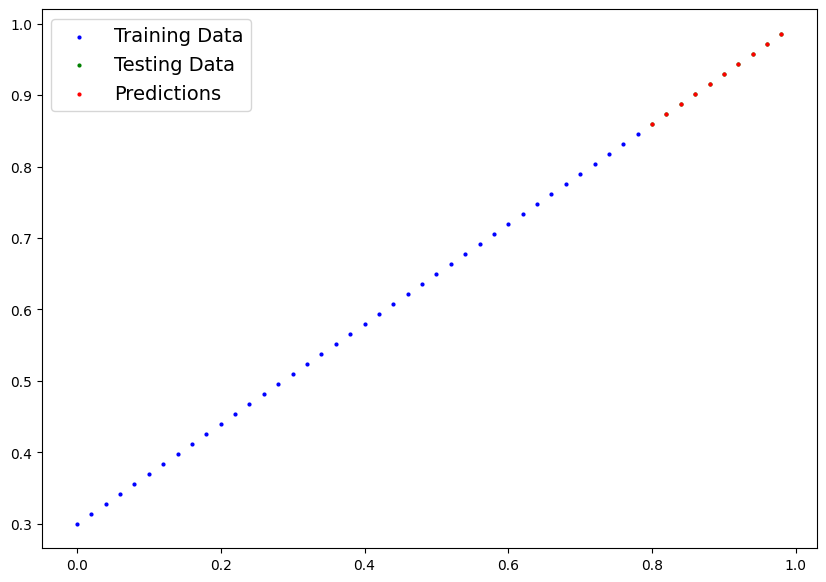

In [47]:
# Checkout model predictions visually
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading a trained model

In [ ]:
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

In [54]:
from pathlib import Path

# 1. create models directory (if not already created)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state_dict()
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [56]:
# Load a PyTorch model

# Create a new instance of linregmodelv2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [58]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [59]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [61]:
# Evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')